In [101]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd

In [102]:
import os
if not os.path.exists('Results'):
   os.makedirs('Results')
if not os.path.exists('Models'):
   os.makedirs('Models')

In [103]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100
NUM_EPOCHS = 50
FEATURES_DISC = 64 
FEATURES_GEN = 64 
NUM_CLASSES = 10
EMBED_SIZE = 100
criticItr = 5

Device: cuda


In [104]:
dataset = datasets.CIFAR10(root="dataset", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


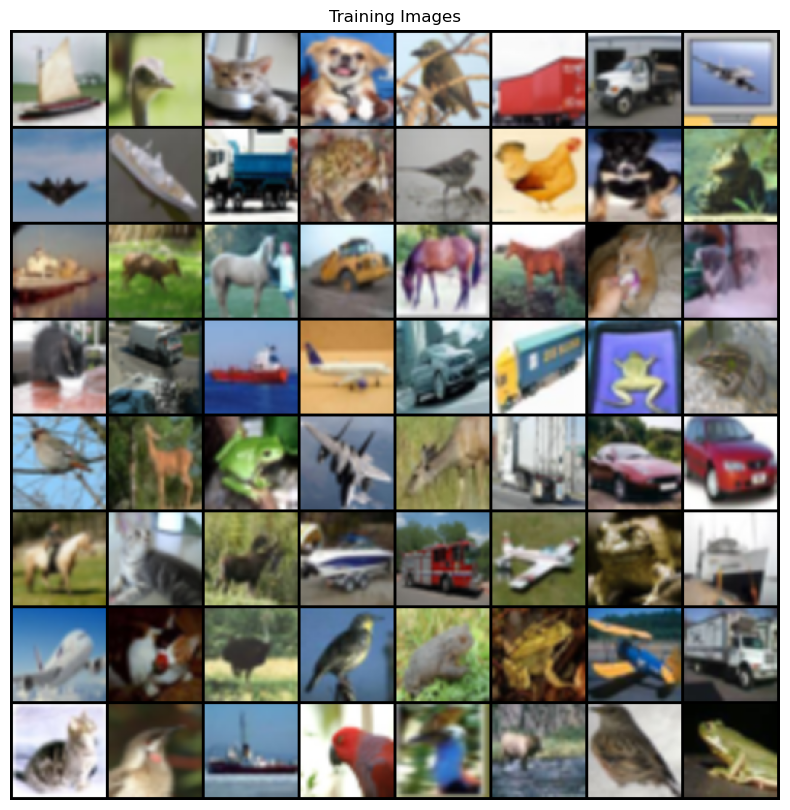

In [105]:
# Retrieve a single batch of images from the dataloader
real_batch = next(iter(dataloader))

# Set up a plot to display the training images
plt.figure(figsize=(10, 10))
plt.axis("off")  # Remove axes for a cleaner display
plt.title("Training Images")

# Create a grid of images from the batch and display it
image_grid = utils.make_grid(
    real_batch[0].to(device)[:BATCH_SIZE],  # Select up to BATCH_SIZE images
    padding=2,  # Add spacing between images
    normalize=True  # Scale image values for display
)
plt.imshow(np.transpose(image_grid.cpu(), (1, 2, 0)))  # Transpose for correct color channel ordering


In [106]:
class Generator(nn.Module):
    def __init__(self, num_classes, img_size, embed_size, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.img_size = img_size

        # Define the main network architecture
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                NOISE_DIM + embed_size,  # Input includes noise and embedded labels
                features_g * 16,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),  # Output: N x (features_g*16) x 4 x 4
            self._create_layer(features_g * 16, features_g * 8, 4, 2, 1),  # Output: N x (features_g*8) x 8 x 8
            self._create_layer(features_g * 8, features_g * 4, 4, 2, 1),  # Output: N x (features_g*4) x 16 x 16
            self._create_layer(features_g * 4, features_g * 2, 4, 2, 1),  # Output: N x (features_g*2) x 32 x 32
            nn.ConvTranspose2d(
                features_g * 2,
                channels_img,
                kernel_size=4,
                stride=2,
                padding=1,
            ),  # Output: N x channels_img x 64 x 64
            nn.Tanh(),  # Normalize output to [-1, 1]
        )

        # Embedding layer for label inputs
        self.embed = nn.Embedding(num_classes, embed_size)

    def _create_layer(self, in_channels, out_channels, kernel_size, stride, padding):
        """
        Helper function to create a block of transposed convolution,
        batch normalization, and ReLU activation.
        """
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, noise, labels):
        """
        Forward pass of the generator.
        :param noise: Input noise tensor of shape (N, noise_dim, 1, 1)
        :param labels: Input class labels of shape (N,)
        :return: Generated images of shape (N, channels_img, img_size, img_size)
        """
        # Embed the labels and expand dimensions for concatenation
        label_embeddings = self.embed(labels).unsqueeze(2).unsqueeze(3)
        # Concatenate noise and embedded labels along the channel dimension
        x = torch.cat([noise, label_embeddings], dim=1)
        # Pass through the generator network
        return self.net(x)


In [107]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size, channels_img, features_d):
        super(Discriminator, self).__init__()

        # Main discriminator network
        self.disc = nn.Sequential(
            nn.Conv2d(
                in_channels=channels_img,  # Number of image channels (e.g., 3 for RGB)
                out_channels=features_d,  # Base feature size
                kernel_size=4,
                stride=2,
                padding=1,
            ),  # Output: N x features_d x (img_size/2) x (img_size/2)
            nn.LeakyReLU(0.2),
            self._create_layer(features_d, features_d * 2, 4, 2, 1),  # Output: N x (features_d*2) x (img_size/4)
            self._create_layer(features_d * 2, features_d * 4, 4, 2, 1),  # Output: N x (features_d*4) x (img_size/8)
            self._create_layer(features_d * 4, features_d * 8, 4, 2, 1),  # Output: N x (features_d*8) x (img_size/16)
        )

        # Validity output layer
        self.validity_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=features_d * 8,
                out_channels=1,  # Single validity score
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Sigmoid(),  # Outputs a scalar validity score in [0, 1]
        )

        # Label prediction layer
        self.label_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=features_d * 8,
                out_channels=num_classes + 1,  # Includes an extra class for "fake"
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.LogSoftmax(dim=1),  # Outputs log-probabilities for classification
        )

        # Class embedding for conditioning (not explicitly used in forward pass)
        self.embed = nn.Embedding(num_classes, img_size * img_size)

    def _create_layer(self, in_channels, out_channels, kernel_size, stride, padding):
        """
        Helper function to create a discriminator block with Conv2d and LeakyReLU.
        """
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        """
        Forward pass of the discriminator.
        :param x: Input tensor of shape (N, channels_img, img_size, img_size)
        :return:
            - `validity`: Validity score for each input (N,)
            - `labels`: Log-probabilities for class predictions (N, num_classes + 1)
        """
        # Pass input through the discriminator network
        x = self.disc(x)

        # Validity score
        validity = self.validity_layer(x).view(-1)

        # Class label predictions
        labels = self.label_layer(x).view(-1, 11)  # 11 includes 10 classes + 1 fake

        return validity, labels


In [108]:
def initialize_weights(model):
    """
    Initialize the weights of Conv2d, ConvTranspose2d, and BatchNorm2d layers 
    using a normal distribution with mean=0.0 and std=0.02, as per the DCGAN paper.
    """
    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(layer.weight.data, mean=0.0, std=0.02)


In [109]:
# Instantiate the Generator and Discriminator
gen = Generator(
    num_classes=NUM_CLASSES,         # Number of classes for conditional generation
    img_size=IMAGE_SIZE,             # Size of the output image
    embed_size=EMBED_SIZE,           # Size of label embeddings
    channels_noise=NOISE_DIM,        # Dimensionality of the noise vector
    channels_img=CHANNELS_IMG,       # Number of image channels (e.g., 3 for RGB)
    features_g=FEATURES_GEN          # Base feature size for the Generator
).to(device)  # Move to the specified device (CPU or GPU)

disc = Discriminator(
    num_classes=NUM_CLASSES,         # Number of classes for conditional discrimination
    img_size=IMAGE_SIZE,             # Size of the input image
    channels_img=CHANNELS_IMG,       # Number of image channels (e.g., 3 for RGB)
    features_d=FEATURES_DISC         # Base feature size for the Discriminator
).to(device)  # Move to the specified device (CPU or GPU)

# Apply weight initialization to both models
initialize_weights(gen)
initialize_weights(disc)


In [110]:
# Set both models to training mode
gen.train()  # Set the Generator to training mode
disc.train()  # Set the Discriminator to training mode


Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (validity_layer): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Sigmoid()
  )
  (label_layer): Sequential(
    (0): Conv2d(512, 11, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LogSoftmax(dim=1)
  )
  (embed): Embedding(10, 4096)
)

In [111]:
class InceptionV3(nn.Module):
    """
    Pretrained InceptionV3 network for extracting feature maps, 
    used for Frechet Inception Distance (FID) calculation.
    """
    DEFAULT_BLOCK_INDEX = 3  # Corresponds to final average pooling layer
    BLOCK_INDEX_BY_DIM = {
        64: 0,    # First max pooling features
        192: 1,   # Second max pooling features
        768: 2,   # Pre-aux classifier features
        2048: 3,  # Final average pooling features
    }

    def __init__(self, output_blocks=None, resize_input=True, normalize_input=True, requires_grad=False):
        """
        Initialize the InceptionV3 model.

        Parameters:
        - output_blocks: List of blocks to extract features from.
        - resize_input: Whether to resize input to (299, 299).
        - normalize_input: Whether to scale input to range [-1, 1].
        - requires_grad: If False, freezes the parameters for feature extraction.
        """
        super(InceptionV3, self).__init__()

        if output_blocks is None:
            output_blocks = [self.DEFAULT_BLOCK_INDEX]

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, "Last possible block index is 3."

        # Load pretrained InceptionV3 model and divide into blocks
        self.blocks = nn.ModuleList()
        inception = models.inception_v3(pretrained=True)

        # Block 0: From input to first max pooling
        self.blocks.append(nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
        ))

        # Block 1: From first to second max pooling
        if self.last_needed_block >= 1:
            self.blocks.append(nn.Sequential(
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2),
            ))

        # Block 2: Pre-auxiliary classifier features
        if self.last_needed_block >= 2:
            self.blocks.append(nn.Sequential(
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ))

        # Block 3: From auxiliary classifier to final average pooling
        if self.last_needed_block >= 3:
            self.blocks.append(nn.Sequential(
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            ))

        # Freeze parameters if requires_grad is False
        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, x):
        """
        Forward pass through the InceptionV3 model.

        Parameters:
        - x: Input tensor of shape (N, 3, H, W).

        Returns:
        - List of feature maps from the specified blocks.
        """
        outputs = []

        # Optionally resize and normalize input
        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        if self.normalize_input:
            x = 2 * x - 1  # Scale input from [0, 1] to [-1, 1]

        # Pass through the blocks and collect outputs
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outputs.append(x)
            if idx == self.last_needed_block:
                break

        return outputs


def calculate_activation_statistics(images, model, batch_size=128, dims=2048, use_cuda=False):
    """
    Compute the mean and covariance of feature maps for a set of images.

    Parameters:
    - images: Batch of images as a PyTorch tensor.
    - model: InceptionV3 model for feature extraction.
    - batch_size: Number of images processed in each batch.
    - dims: Dimensionality of the features (default: 2048 for final pooling).
    - use_cuda: Whether to use CUDA for processing.

    Returns:
    - mu: Mean of the feature maps.
    - sigma: Covariance of the feature maps.
    """
    model.eval()  # Set model to evaluation mode
    features = np.empty((len(images), dims))

    # Process images
    with torch.no_grad():
        if use_cuda:
            images = images.cuda()

        pred = model(images)[0]  # Extract features

        # Apply global average pooling if necessary
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))

        features = pred.cpu().numpy().reshape(pred.size(0), -1)

    # Compute mean and covariance
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Compute the Frechet Distance between two distributions.

    Parameters:
    - mu1, sigma1: Mean and covariance of the first distribution.
    - mu2, sigma2: Mean and covariance of the second distribution.
    - eps: Small value added to the diagonal for numerical stability.

    Returns:
    - Frechet Distance between the two distributions.
    """
    mu1, mu2 = np.atleast_1d(mu1), np.atleast_1d(mu2)
    sigma1, sigma2 = np.atleast_2d(sigma1), np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Mean vectors must have the same length."
    assert sigma1.shape == sigma2.shape, "Covariance matrices must have the same dimensions."

    diff = mu1 - mu2

    # Compute the square root of the product of covariance matrices
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        covmean = linalg.sqrtm((sigma1 + np.eye(sigma1.shape[0]) * eps).dot(sigma2 + np.eye(sigma2.shape[0]) * eps))

    # Ensure no complex values
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)


def calculate_fid(images_real, images_fake, model):
    """
    Compute the Frechet Inception Distance (FID) between two sets of images.

    Parameters:
    - images_real: Real images as a PyTorch tensor.
    - images_fake: Generated (fake) images as a PyTorch tensor.
    - model: Pretrained InceptionV3 model for feature extraction.

    Returns:
    - FID value (float): Frechet Distance between the feature distributions.
    """
    mu1, sigma1 = calculate_activation_statistics(images_real, model, use_cuda=True)
    mu2, sigma2 = calculate_activation_statistics(images_fake, model, use_cuda=True)
    return calculate_frechet_distance(mu1, sigma1, mu2, sigma2)


In [112]:
# Generate a batch of fixed noise vectors for consistent input during evaluation
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)  # Shape: (32, NOISE_DIM, 1, 1)

# Initialize a step counter for tracking iterations
step = 0


In [113]:
# Optimizers for the Generator and Discriminator
disOptim = optim.Adam(
    disc.parameters(),          # Parameters of the Discriminator
    lr=LEARNING_RATE,           # Learning rate
    betas=(0.5, 0.999)          # Beta values for Adam optimizer
)
genOptim = optim.Adam(
    gen.parameters(),           # Parameters of the Generator
    lr=LEARNING_RATE,           # Learning rate
    betas=(0.5, 0.999)          # Beta values for Adam optimizer
)

# Loss function for binary classification
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# Variables to track training progress
counterList = []  # List to store iteration counters (useful for plotting)
counter = 0       # Initialize a counter for tracking iterations
genLossList = []  # List to store generator losses
disLossList = []  # List to store discriminator losses
img_list = []     # List to store generated images during evaluation


In [114]:
# samp1
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, use_cuda=False):
    """
    Compute the mean and covariance of feature maps for a set of images.

    Parameters:
    - images: Batch of images as a PyTorch tensor.
    - model: InceptionV3 model for feature extraction.
    - batch_size: Number of images processed in each batch.
    - dims: Dimensionality of the features (default: 2048 for final pooling).
    - use_cuda: Whether to use CUDA for processing.

    Returns:
    - mu: Mean of the feature maps.
    - sigma: Covariance of the feature maps.
    """
    model.eval()  # Set model to evaluation mode
    features = np.empty((len(images), dims))

    with torch.no_grad():
        if use_cuda:
            images = images.cuda()

        pred = model(images)[0]  # Extract features

        # Apply global average pooling if necessary
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))

        features = pred.cpu().numpy().reshape(pred.size(0), -1)

    # Compute mean and covariance
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma


def calculate_fretchet(images_real, images_fake, model):
    """
    Compute the Frechet Inception Distance (FID) between real and fake images.

    Parameters:
    - images_real: Real images as a PyTorch tensor.
    - images_fake: Generated (fake) images as a PyTorch tensor.
    - model: Pretrained InceptionV3 model for feature extraction.

    Returns:
    - FID value (float): Frechet Distance between the feature distributions.
    """
    mu_1, std_1 = calculate_activation_statistics(images_real, model, use_cuda=True)
    mu_2, std_2 = calculate_activation_statistics(images_fake, model, use_cuda=True)

    # Compute Frechet distance using calculated statistics
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value


In [115]:
# # sam2
# GenLoss = []      # Generator loss at each batch
# DiscLoss = []     # Discriminator loss at each batch
# img_list = []     # Saved images for visualization
# iters = 0         # Total number of iterations
# FID_list = []     # List to store FID scores

# print("!!Training Started!!")

# # Start timing the training process
# time_start = time.time()

# for epoch in range(1, NUM_EPOCHS + 1):  # Start epoch index at 1 for readability
#     for batch_idx, (realImg, labels) in enumerate(dataloader):
#         # Move real images and labels to the device
#         real = realImg.to(device)
#         labels = labels.to(device)
#         miniBatch = real.size(0)

#         # Define fake class label for discriminator training
#         fakeClassLabel = 10 * torch.ones((miniBatch,), dtype=torch.long).to(device)

#         # Reset gradients for the discriminator
#         disc.zero_grad()

#         ##########################
#         ### Train Discriminator ###
#         ##########################

#         # Train on real images
#         real_labels = torch.full((miniBatch,), 1.0, dtype=torch.float).to(device)
#         disc_real, disc_label = disc(real)
#         loss_disc_real_val = criterion(disc_real, real_labels)
#         loss_disc_real_label = F.nll_loss(disc_label, labels)
#         real_loss_disc = loss_disc_real_val + loss_disc_real_label
#         real_loss_disc.backward()

#         # Train on fake images
#         sample_label = torch.randint(0, 10, (miniBatch,), dtype=torch.long).to(device)
#         noise = torch.randn(miniBatch, NOISE_DIM, 1, 1).to(device)
#         fake = gen(noise, sample_label)
#         disc_fake, disc_fake_label = disc(fake.detach())
#         fake_labels = torch.full((miniBatch,), 0.0, dtype=torch.float).to(device)
#         loss_disc_fake_val = criterion(disc_fake, fake_labels)
#         loss_disc_fake_label = F.nll_loss(disc_fake_label, fakeClassLabel)
#         fake_loss_disc = loss_disc_fake_val + loss_disc_fake_label
#         fake_loss_disc.backward()

#         # Update discriminator weights
#         loss_disc = (real_loss_disc + fake_loss_disc) / 2
#         disOptim.step()

#         ##########################
#         ### Train Generator ###
#         ##########################

#         # Reset gradients for the generator
#         gen.zero_grad()

#         # Generate fake images
#         noise = torch.randn(miniBatch, NOISE_DIM, 1, 1).to(device)
#         sample_label = torch.randint(0, 10, (miniBatch,), dtype=torch.long).to(device)
#         fake = gen(noise, sample_label)
#         gen_output, gen_output_label = disc(fake)

#         # Compute generator loss
#         gen_labels = torch.full((miniBatch,), 1.0, dtype=torch.float).to(device)
#         loss_gen_val = criterion(gen_output, gen_labels)
#         loss_gen_label = F.nll_loss(gen_output_label, sample_label)
#         loss_gen = loss_gen_val + loss_gen_label
#         loss_gen.backward()

#         # Update generator weights
#         genOptim.step()

#         # Track losses
#         GenLoss.append(loss_gen.item())
#         DiscLoss.append(loss_disc.item())

#         # Save generated images for visualization
#         if iters % 500 == 0 or (epoch == NUM_EPOCHS and batch_idx == len(dataloader) - 1):
#             with torch.no_grad():
#                 fake_images = gen(noise, sample_label).detach().cpu()
#             img_list.append(utils.make_grid(fake_images, padding=2, normalize=True))

#         iters += 1

#     ######################
#     ### Calculate FID ###
#     ######################
#     fretchet_dist = calculate_fretchet(real, fake, model)
#     FID_list.append(fretchet_dist)

#     # Print progress every 5 epochs
#     if epoch % 5 == 0:
#         print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} "
#               f"Loss D: {loss_disc:.3f}, Loss G: {loss_gen:.3f}, FID: {fretchet_dist:.3f}")

#     ###############################
#     ### Save Generated Images ###
#     ###############################
#     # Create result directories if they don't exist
#     os.makedirs('Results/ACGAN_FAKE', exist_ok=True)
#     os.makedirs('Results/ACGAN_REAL', exist_ok=True)

#     # Save fake images generated in the current epoch
#     fake_images = gen(noise, sample_label).detach()
#     utils.save_image(fake_images, f'Results/ACGAN_FAKE/ACGAN_epoch_{epoch:03d}.png', normalize=True)

#     # Save real images from the current batch
#     utils.save_image(real, f'Results/ACGAN_REAL/ACGAN_epoch_{epoch:03d}.png', normalize=True)

# # End timing
# time_end = time.time()
# print(f'\n\nElapsed time: {time_end - time_start:.2f} seconds.')


!!Training Started!!
Epoch [5/50] Batch 781/782 Loss D: 2.195, Loss G: 2.830, FID: 422.419


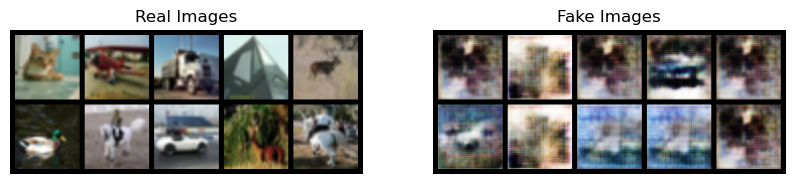

Epoch [10/50] Batch 781/782 Loss D: 2.024, Loss G: 2.470, FID: 387.374


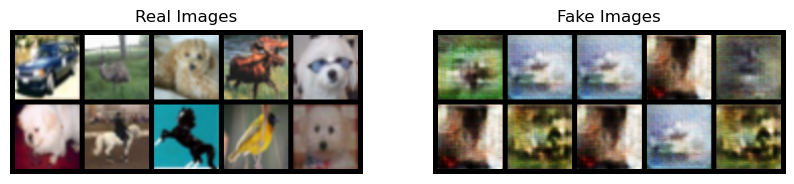

Epoch [15/50] Batch 781/782 Loss D: 1.415, Loss G: 2.823, FID: 349.415


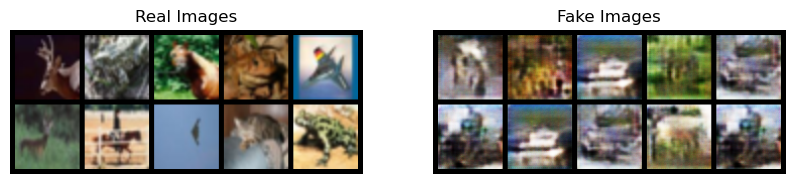

Epoch [20/50] Batch 781/782 Loss D: 1.660, Loss G: 3.222, FID: 316.707


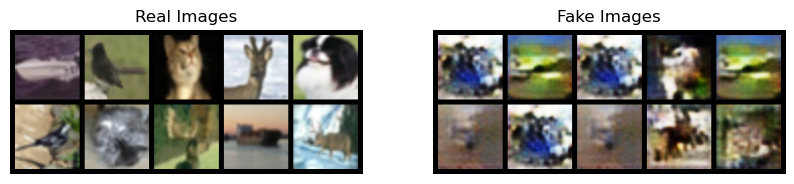

Epoch [25/50] Batch 781/782 Loss D: 1.364, Loss G: 3.363, FID: 298.252


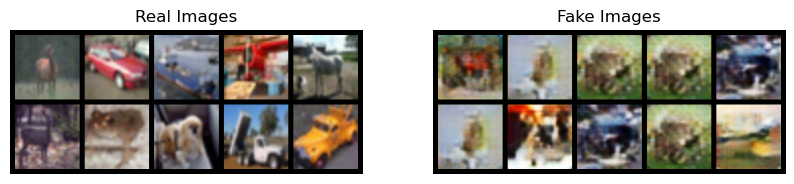

Epoch [30/50] Batch 781/782 Loss D: 1.879, Loss G: 5.461, FID: 284.615


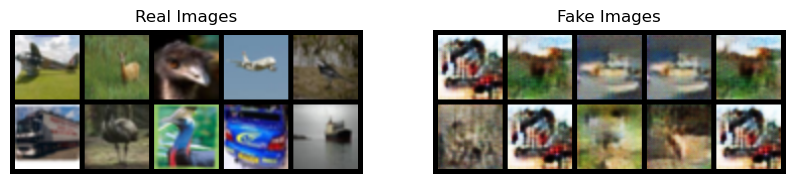

Epoch [35/50] Batch 781/782 Loss D: 1.346, Loss G: 5.932, FID: 306.437


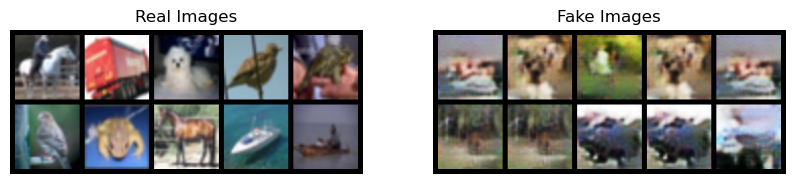

Epoch [40/50] Batch 781/782 Loss D: 1.832, Loss G: 3.872, FID: 294.166


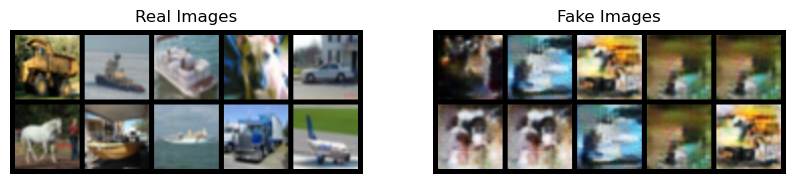

Epoch [45/50] Batch 781/782 Loss D: 1.543, Loss G: 4.429, FID: 295.089


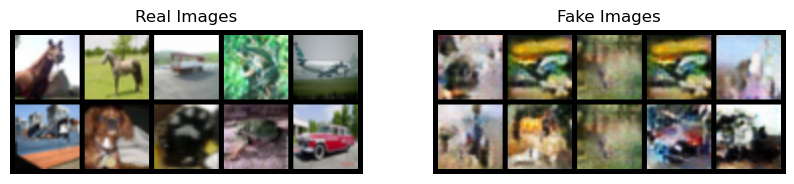

Epoch [50/50] Batch 781/782 Loss D: 1.238, Loss G: 4.224, FID: 288.753


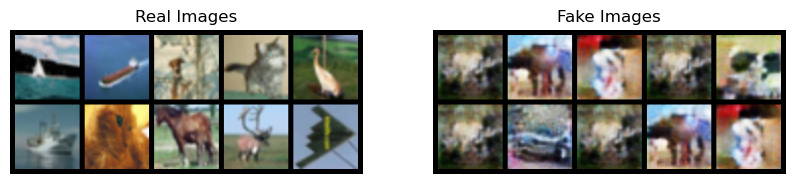



Elapsed time: 796.15 seconds.


In [116]:
import matplotlib.pyplot as plt

# Initialize tracking lists and counters
GenLoss = []      # Generator loss for each batch
DiscLoss = []     # Discriminator loss for each batch
img_list = []     # List for storing generated images
iters = 0         # Iteration counter
FID_list = []     # List for storing FID scores

print("!!Training Started!!")

# Start the timer
time_start = time.time()

for epoch in range(1, NUM_EPOCHS + 1):  # Start epoch index at 1 for clarity
    for batch_idx, (realImg, labels) in enumerate(dataloader):
        # Move real images and labels to the device (e.g., GPU)
        real = realImg.to(device)
        labels = labels.to(device)
        miniBatch = real.size(0)

        # Fake class label for discriminator training
        fakeClassLabel = 10 * torch.ones((miniBatch,), dtype=torch.long).to(device)

        # Reset gradients for the discriminator
        disc.zero_grad()

        ############################
        ### Train Discriminator ###
        ############################

        # Train on real images
        real_labels = torch.full((miniBatch,), 1.0, dtype=torch.float).to(device)  # Real label = 1.0
        disc_real, disc_label = disc(real)  # Discriminator predictions on real images
        loss_disc_real_val = criterion(disc_real, real_labels)  # Binary cross-entropy loss
        loss_disc_real_label = F.nll_loss(disc_label, labels)  # Class label loss
        real_loss_disc = loss_disc_real_val + loss_disc_real_label
        real_loss_disc.backward()  # Backpropagation for real batch

        # Train on fake images
        sample_label = torch.randint(0, 10, (miniBatch,), dtype=torch.long).to(device)  # Random fake labels
        noise = torch.randn(miniBatch, NOISE_DIM, 1, 1).to(device)  # Random noise input
        fake = gen(noise, sample_label)  # Generate fake images
        disc_fake, disc_fake_label = disc(fake.detach())  # Discriminator predictions on fake images
        fake_labels = torch.full((miniBatch,), 0.0, dtype=torch.float).to(device)  # Fake label = 0.0
        loss_disc_fake_val = criterion(disc_fake, fake_labels)  # Binary cross-entropy loss
        loss_disc_fake_label = F.nll_loss(disc_fake_label, fakeClassLabel)  # Class label loss for fakes
        fake_loss_disc = loss_disc_fake_val + loss_disc_fake_label
        fake_loss_disc.backward()  # Backpropagation for fake batch

        # Update discriminator weights
        loss_disc = (real_loss_disc + fake_loss_disc) / 2
        disOptim.step()

        ############################
        ### Train Generator ###
        ############################

        # Reset gradients for the generator
        gen.zero_grad()

        # Generate fake images
        noise = torch.randn(miniBatch, NOISE_DIM, 1, 1).to(device)
        sample_label = torch.randint(0, 10, (miniBatch,), dtype=torch.long).to(device)
        fake = gen(noise, sample_label)
        gen_output, gen_output_label = disc(fake)

        # Compute generator loss
        gen_labels = torch.full((miniBatch,), 1.0, dtype=torch.float).to(device)  # Target label = 1.0
        loss_gen_val = criterion(gen_output, gen_labels)  # Binary cross-entropy loss
        loss_gen_label = F.nll_loss(gen_output_label, sample_label)  # Class label loss
        loss_gen = loss_gen_val + loss_gen_label
        loss_gen.backward()  # Backpropagation for generator

        # Update generator weights
        genOptim.step()

        # Track losses
        GenLoss.append(loss_gen.item())
        DiscLoss.append(loss_disc.item())

        # Save generated images for visualization at intervals
        if iters % 500 == 0 or (epoch == NUM_EPOCHS and batch_idx == len(dataloader) - 1):
            with torch.no_grad():
                fake_images = gen(noise, sample_label).detach().cpu()
            img_list.append(utils.make_grid(fake_images, padding=2, normalize=True))

        iters += 1

    ###########################
    ### Calculate FID Score ###
    ###########################
    fretchet_dist = calculate_fretchet(real, fake, model)
    FID_list.append(fretchet_dist)

    ###########################
    ### Print Images ###
    ###########################
    if epoch % 5 == 0:
        print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} "
              f"Loss D: {loss_disc:.3f}, Loss G: {loss_gen:.3f}, FID: {fretchet_dist:.3f}")
        
        # Plot real and fake images
        plt.figure(figsize=(10, 5))
        
        # Plot real images
        plt.subplot(1, 2, 1)
        plt.axis("off")
        plt.title("Real Images")
        plt.imshow(np.transpose(utils.make_grid(real[:10], nrow=5, padding=5, normalize=True).cpu(), (1, 2, 0)))
        
        # Plot fake images
        plt.subplot(1, 2, 2)
        plt.axis("off")
        plt.title("Fake Images")
        plt.imshow(np.transpose(utils.make_grid(fake[:10], nrow=5, padding=5, normalize=True).cpu(), (1, 2, 0)))
        
        plt.show()

    ###########################
    ### Save Epoch Results ###
    ###########################
    os.makedirs('Results/ACGAN_FAKE', exist_ok=True)
    os.makedirs('Results/ACGAN_REAL', exist_ok=True)

    # Save fake images generated in the current epoch
    fake_images = gen(noise, sample_label).detach()
    utils.save_image(fake_images, f'Results/ACGAN_FAKE/ACGAN_epoch_{epoch:03d}.png', normalize=True)

    # Save real images from the current batch
    utils.save_image(real, f'Results/ACGAN_REAL/ACGAN_epoch_{epoch:03d}.png', normalize=True)

# End timing
time_end = time.time()
print(f'\n\nElapsed time: {time_end - time_start:.2f} seconds.')


In [117]:
# Create directory for saving loss data if it does not exist
os.makedirs('Results/Loss_Data', exist_ok=True)

# Save generator and discriminator loss data as numpy arrays
np.save('Results/Loss_Data/ACGAN_GLoss.npy', GenLoss)
np.save('Results/Loss_Data/ACGAN_DLoss.npy', DiscLoss)


In [118]:
GenLoss = np.load('Results/Loss_Data/ACGAN_GLoss.npy')
DiscLoss = np.load('Results/Loss_Data/ACGAN_DLoss.npy')

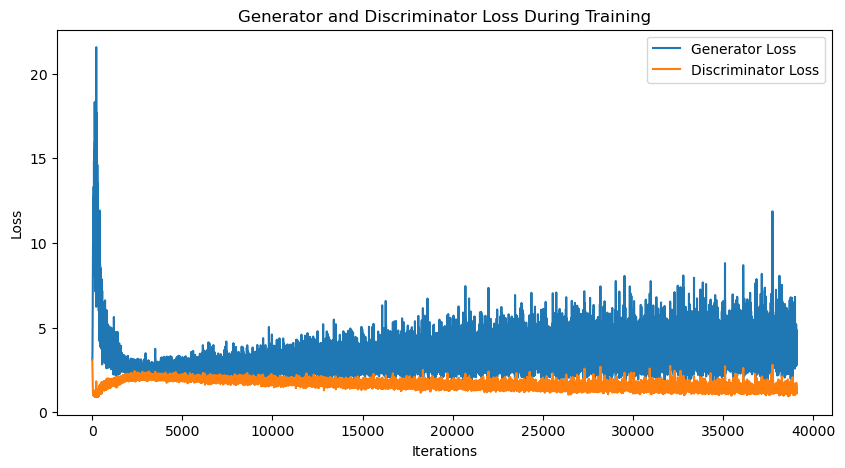

In [119]:
# Plot generator and discriminator losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")  # Plot title

# Plot the generator and discriminator losses
plt.plot(GenLoss, label="Generator Loss")
plt.plot(DiscLoss, label="Discriminator Loss")

# Add labels and legend
plt.xlabel("Iterations")  # X-axis label
plt.ylabel("Loss")        # Y-axis label
plt.legend()              # Display legend

# Save the plot to a PDF file
os.makedirs('Results', exist_ok=True)  # Ensure the Results directory exists
plt.savefig(
    'Results/LOSS.pdf',    # File path
    format='pdf',          # Save as PDF
    dpi=100,               # Resolution
    bbox_inches='tight'    # Fit plot tightly within the PDF
)

# Display the plot
plt.show()


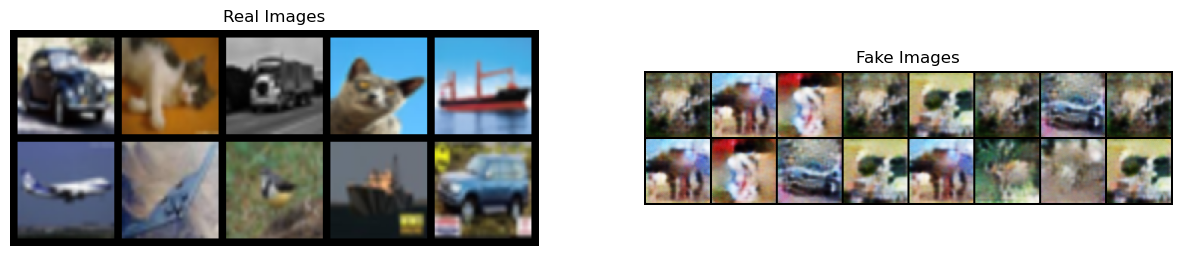

In [120]:
# Fetch a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Set up a figure for displaying images
plt.figure(figsize=(15, 15))

# Plot Real Images
plt.subplot(1, 2, 1)  # Left plot
plt.axis("off")       # Turn off axes
plt.title("Real Images")  # Add title
plt.imshow(
    np.transpose(
        utils.make_grid(
            real_batch[0].to(device)[:10],  # Select the first 10 images
            nrow=5,                         # Number of images per row
            padding=5,                      # Add padding between images
            normalize=True                  # Normalize pixel values
        ).cpu(), 
        (1, 2, 0)  # Transpose to match image format (H, W, C)
    )
)

# Plot Fake Images
plt.subplot(1, 2, 2)  # Right plot
plt.axis("off")       # Turn off axes
plt.title("Fake Images")  # Add title
plt.imshow(
    np.transpose(
        img_list[-1],  # Use the last set of generated images
        (1, 2, 0)      # Transpose to match image format (H, W, C)
    )
)

# Save the figure as a PDF file
os.makedirs('Results', exist_ok=True)  # Ensure the Results directory exists
plt.savefig(
    'Results/ACGAN_BEST_FAKE_32.pdf',  # File path
    format='pdf',                       # Save as PDF
    dpi=100,                            # Resolution
    bbox_inches='tight'                 # Fit plot tightly within the PDF
)

# Display the figure
plt.show()


In [121]:
len(img_list)

80

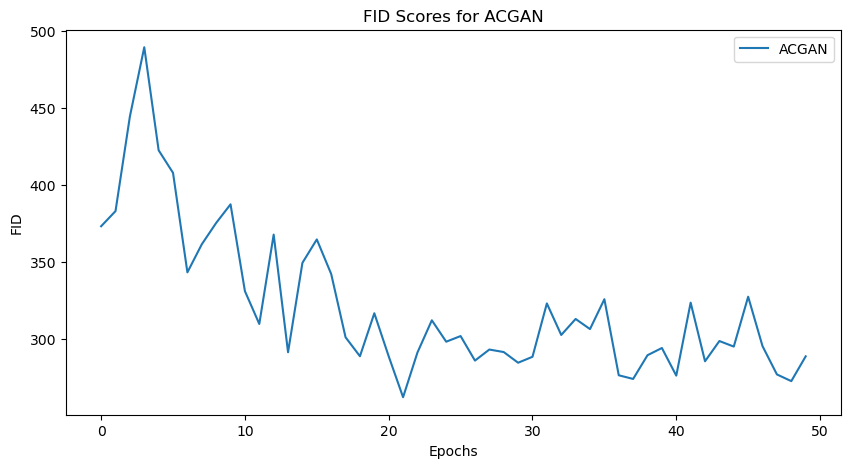

In [122]:
# Plot FID Scores
plt.figure(figsize=(10, 5))  # Set figure size
plt.title("FID Scores for ACGAN")  # Add title

# Plot FID scores for DCGAN
plt.plot(FID_list, label="ACGAN")

# Uncomment to plot additional scores (e.g., for WGAN)
# plt.plot(W_FIDScore, label="WGAN")

# Add axis labels and legend
plt.xlabel("Epochs")  # Label for the x-axis
plt.ylabel("FID")     # Label for the y-axis
plt.legend()          # Add legend to the plot

# Save the plot as a PDF file
os.makedirs('Results', exist_ok=True)  # Ensure the Results directory exists
plt.savefig(
    'Results/FID.pdf',       # File path
    format='pdf',            # Save as PDF
    bbox_inches='tight'      # Fit plot tightly within the PDF
)

# Display the plot
plt.show()


In [123]:
if not os.path.exists('Results/FID_score'):
       os.makedirs('Results/FID_score')
np.save('Results/FID_score/ACGAN_FID', FID_list) 

In [124]:
np.min(FID_list), np.max(FID_list), np.mean(FID_list), FID_list[-5]

(262.2401320133385, 489.27731869580174, 321.88138293726706, 327.4373482191247)

In [125]:
np.mean(GenLoss),np.mean(DiscLoss),np.min(GenLoss),np.min(DiscLoss),GenLoss[-1],DiscLoss[-1]

(3.3881363887555156,
 1.6391000150902497,
 1.4032751321792603,
 0.8835930228233337,
 4.224305152893066,
 1.2375540733337402)